# Reporte de práctica 8: Análisis de varianza y de componentes principales

En ésta práctica haremos análisis de varianza(ANOVA) a los datos de las prácticas anteriores.

## Objetivo

Realizar un ANOVA y un (Análisis de componentes principales)PCA

In [1]:
import statsmodels.api as sm
from numpy import isnan
import pandas as pd
cine = pd.read_excel('https://raw.githubusercontent.com/SamatarouKami/CIENCIA_DE_DATOS/master/2018.xlsx', index_col=None, header=0, sheet_name=0)
cine = cine[['Categoria','Edad','Pais', 'Titulo','Genero', 'Duracion', 'Marca','Referencia','Dias','Marcas','Personas','Sinopsis']]

cine = cine.dropna()

print(len(cine))

266


In [2]:
from statsmodels.formula.api import ols

cine['sin'] = cine["Sinopsis"].str.len()

m = ols('sin ~ Categoria + Genero + Marca', data = cine).fit() 
a = sm.stats.anova_lm(m, typ = 2)
print(a)
n = len(a)
alpha = 0.05
for i in range(n):
    print("{:s} {:s}es significativo".format(a.index[i], "" if a['PR(>F)'][i] < alpha else "no "))

                 sum_sq     df         F    PR(>F)
Categoria  5.750218e+05    5.0  0.739158  0.594787
Genero     1.095395e+06    8.0  0.880043  0.533914
Marca      3.968436e+06   14.0  1.821857  0.036235
Residual   3.718561e+07  239.0       NaN       NaN
Categoria no es significativo
Genero no es significativo
Marca es significativo
Residual no es significativo


KeyError: 0

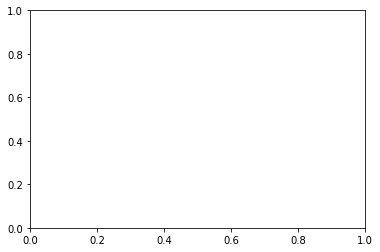

In [4]:
import matplotlib.pyplot as plt
lvls = cine.groupby(['Edad', 'Personas'])
fig, ax = plt.subplots()
col = ['b', 'g']
means = dict()
stddevs = dict()
lbls = []
for (sem, est), datos in lvls:
    if sem not in means:
        means[sem] = dict()
        stddevs[sem] = dict()
    if est not in lbls:
        lbls.append(est)
    means[sem][est] = datos.sin.mean()
    stddevs[sem][est] = datos.sin.std()
n = len(lbls)
i = 0
for sem in means:
    m = [means[sem][est] for est in lbls]
    sd = [stddevs[sem][est] for est in lbls]
    pos = [j + i * bw for j in range(n)]
    ax.bar(pos, m, bw, alpha = 0.5, color = col.pop(0), yerr = sd, \
           error_kw = {'ecolor': '0.3'}, label = sem)
    i += 1
#ax.set_xlabel('Estimado a medio curso')
#ax.set_ylabel('Calificación de primera oportunidad')
#ax.set_xticks([i + bw / 2 for i in range(n)])
#ax.set_xticklabels(['{:.0f}'.format(e) for e in means['enero'].keys()])
#ax.legend()
fig.tight_layout()
plt.show()